In [1]:
from datamodule.datamodule import *
from distributions.distributions import *
from utils import *
# MODEL:
from model.deepGARv1 import DeepGAR
# PYTORCH LIGHTNING:
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
#

# Dataset
- you have to specify each param of the dataset

In [2]:
name = 'exchange'  # electric
train_size = 0.7
validation_size = 0.15
test_size = 0.15
custom_datamodule = DataModule(name, (train_size, validation_size, test_size))

In [3]:
train_window = 24
test_window = 24
test_horizon = 8
test_stride = 8  # should be equal to the time horizon
test_delay = 0
train_loader, val_loader, test_loader = custom_datamodule.get_all(
    window=train_window,
    test_window=test_window,
    test_horizon=test_horizon,
    test_stride=test_stride,
    test_delay=test_delay
)

Train (5067, 8), val (1382, 8), test (1139, 8). ORIGINAL (7588, 8)


In [4]:
input_size = custom_datamodule.get_channels()
n_nodes = custom_datamodule.get_number_of_nodes()

distribution = GaussianDistribution()  # or StudentTDistribution()

In [5]:
model = DeepGAR(
        input_size=input_size,
        n_nodes=n_nodes,
        distribution=distribution,
        learning_rate=0.001
)
print(model)
print_model_size(model)

early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        min_delta=0.00,
        patience=20,
        mode='min'
    )
checkpoint_callback = ModelCheckpoint(
        dirpath=f'exchange_logs',
        save_top_k=1,
        monitor='val_loss',
        mode='min',
    )
trainer = pl.Trainer(
        max_epochs=1000,
        accelerator='cuda' if torch.cuda.is_available() else 'cpu',
        devices = 1,
        callbacks=[checkpoint_callback, early_stopping_callback],
        log_every_n_steps=100,
    )

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


DeepGAR(
  (train_loss_fn): NLL()
  (test_loss_fn): RMSE_paper()
  (distribution_sigma): Softplus(beta=1, threshold=20)
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (node_embeddings): NodeEmbedding(n_nodes=8, embedding_size=32)
  (time): MultiLSTMCell(hidden_size=32)
  (space_time): GraphConvLSTMCell(hidden_size=32)
  (space_time_2): GraphConvLSTMCell(hidden_size=32)
  (distribution_mu): Linear(in_features=32, out_features=1, bias=True)
  (distribution_presigma): Linear(in_features=32, out_features=1, bias=True)
)
Number of model (DeepGAR) parameters:     99970


/Users/marziolunghi/Documents/GitHub/DeepGAR/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [7]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name                  | Type              | Params
------------------------------------------------------------
0 | train_loss_fn         | NLL               | 0     
1 | test_loss_fn          | RMSE_paper        | 0     
2 | distribution_sigma    | Softplus          | 0     
3 | encoder               | Linear            | 64    
4 | node_embeddings       | NodeEmbedding     | 256   
5 | time                  | MultiLSTMCell     | 66.6 K
6 | space_time            | GraphConvLSTMCell | 16.5 K
7 | space_time_2          | GraphConvLSTMCell | 16.5 K
8 | distribution_mu       | Linear            | 33    
9 | distribution_presigma | Linear            | 33    
------------------------------------------------------------
100.0 K   Trainable params
0         Non-trainable params
100.0 K   Total params
0.400     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [6]:
best_model_path = checkpoint_callback.best_model_path
best_model_path = './exchange_logs/epoch=1-step=316.ckpt'
best_model = DeepGAR.load_from_checkpoint(
    checkpoint_path=best_model_path
)
best_model.eval()
res = trainer.predict(model=best_model, dataloaders=test_loader)

Predicting: 0it [00:00, ?it/s]

In [7]:
get_metrics(res, horizon=test_horizon, n_nodes=n_nodes)

(1, 8, 1112)
(1, 8, 1112)
(8, 1112)
(8, 1112)


(0.003878306017872508, 0.033440918)

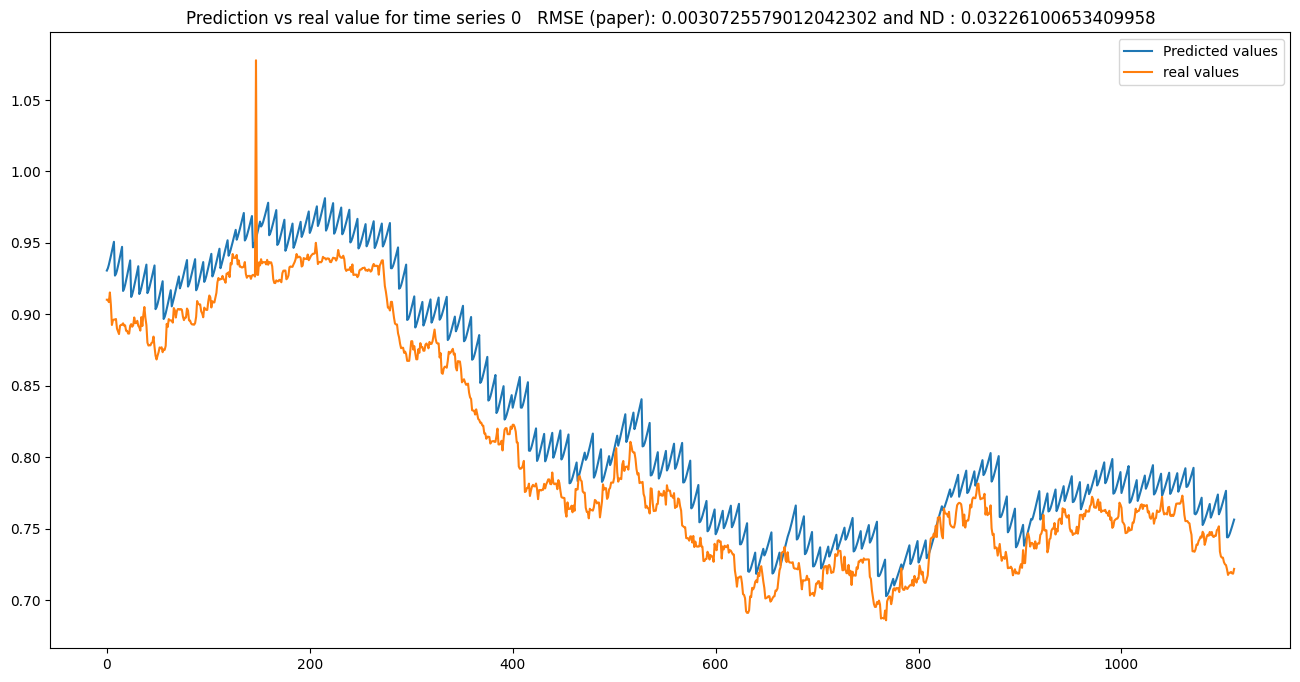

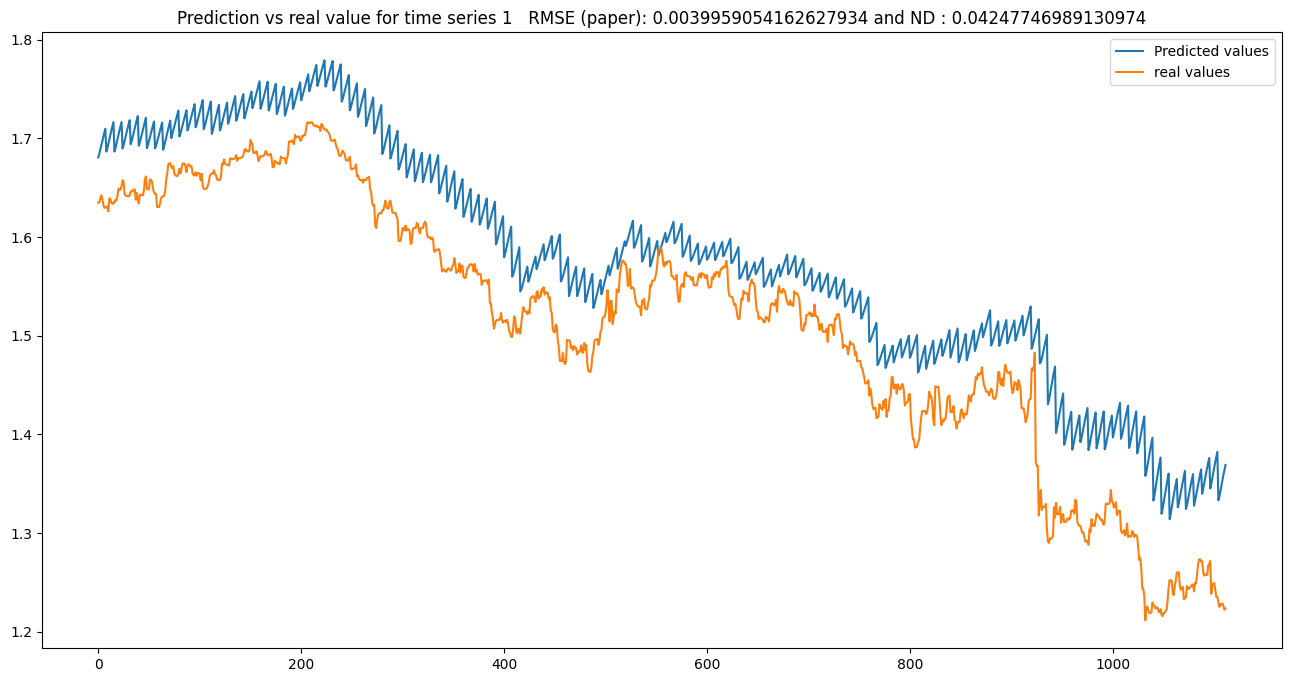

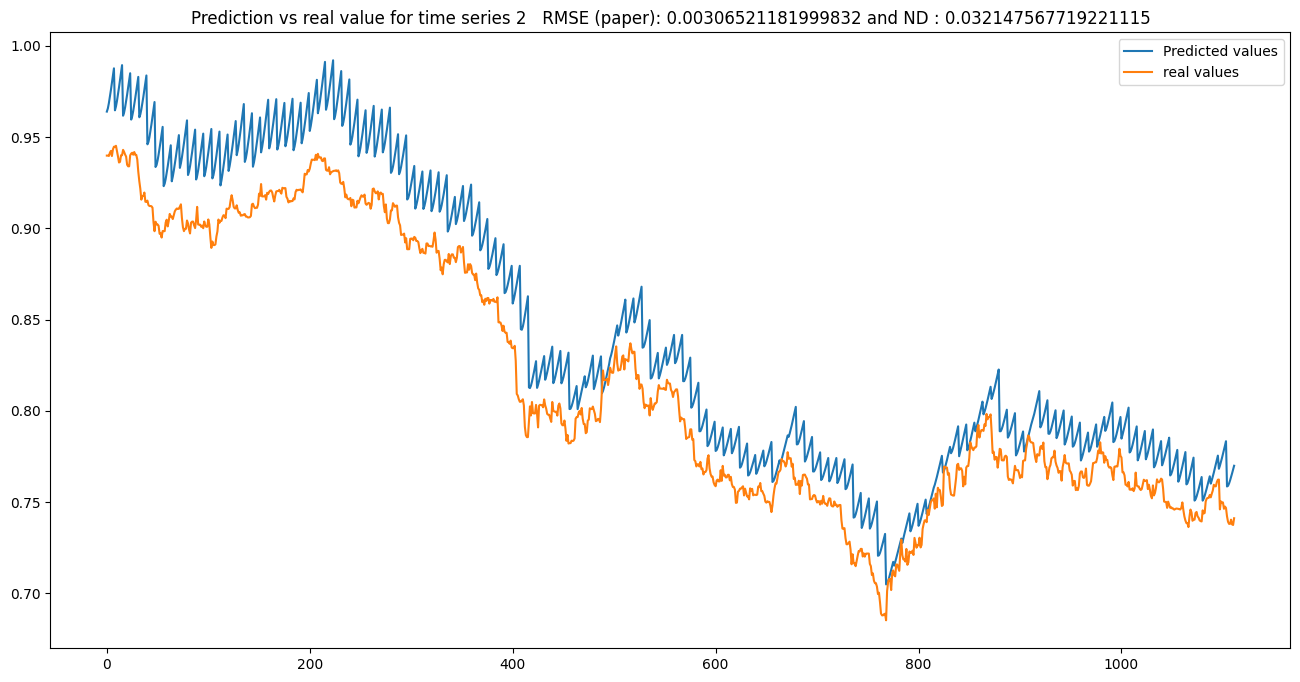

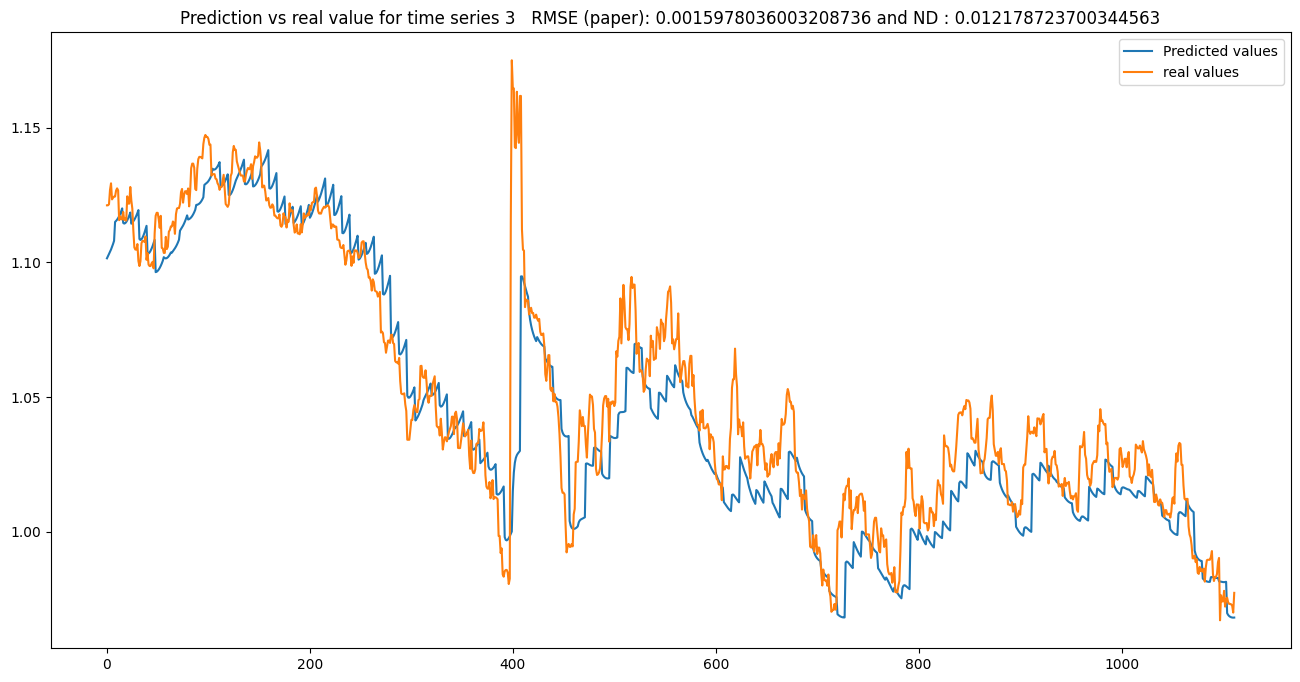

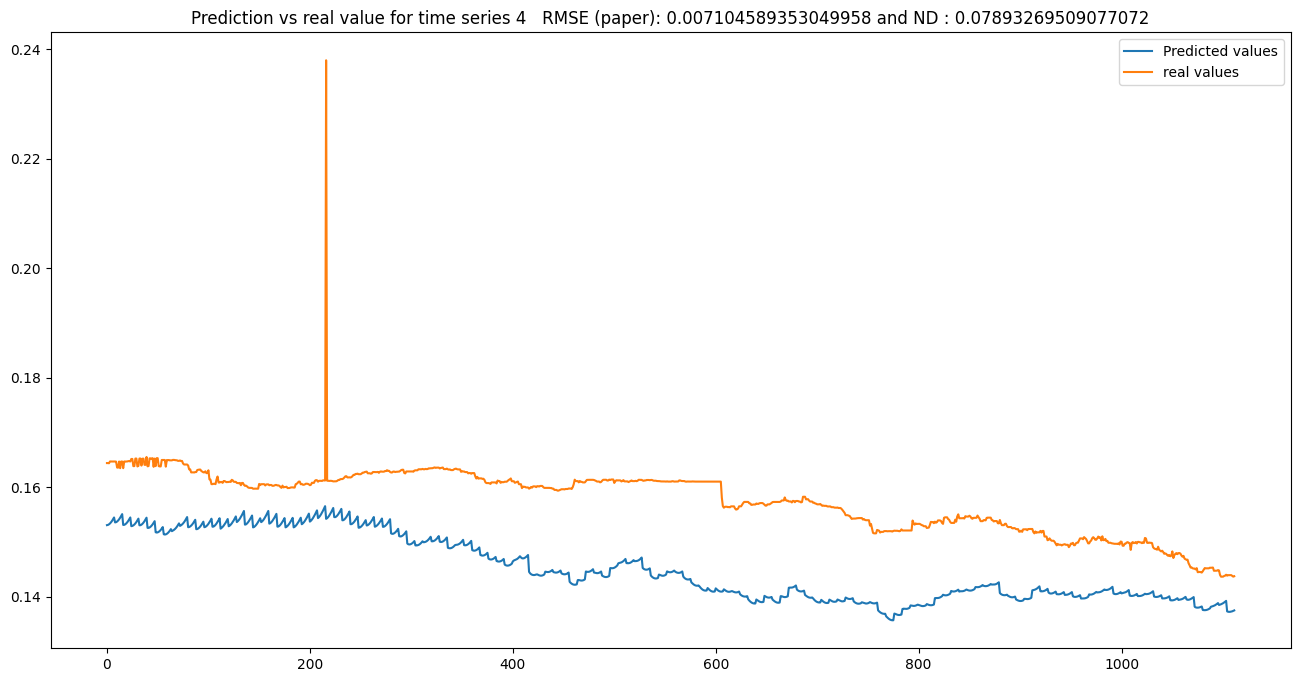

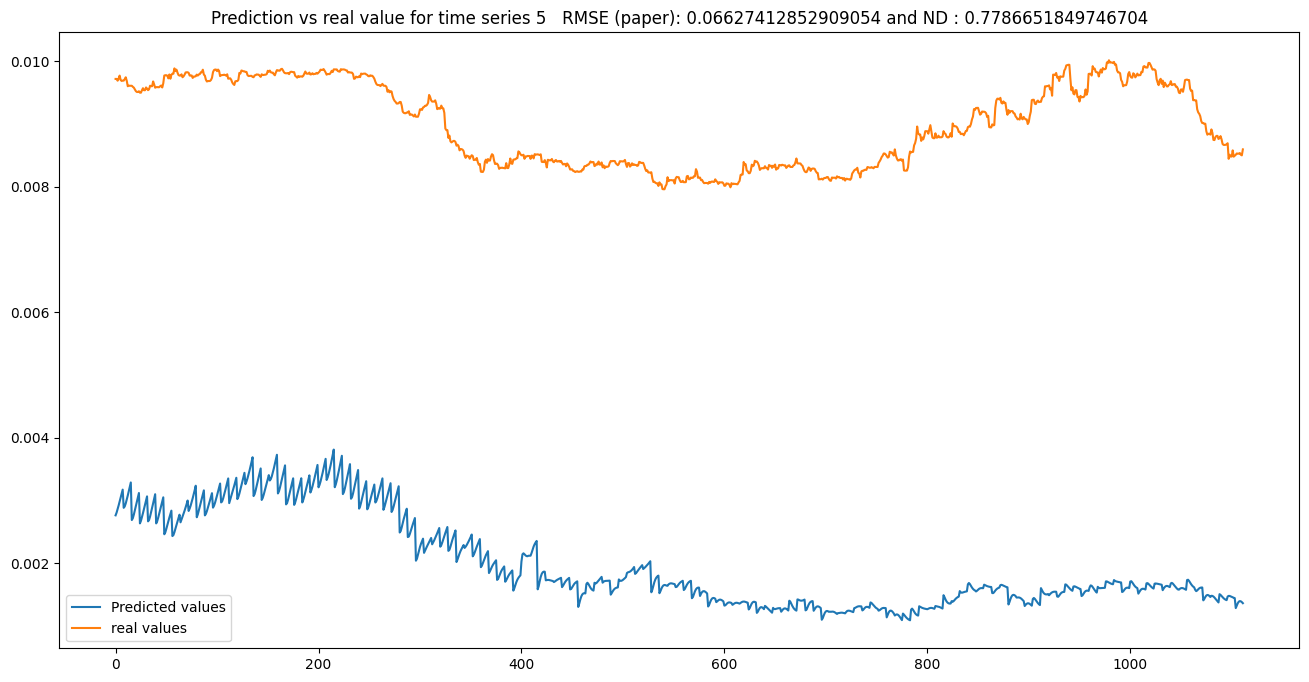

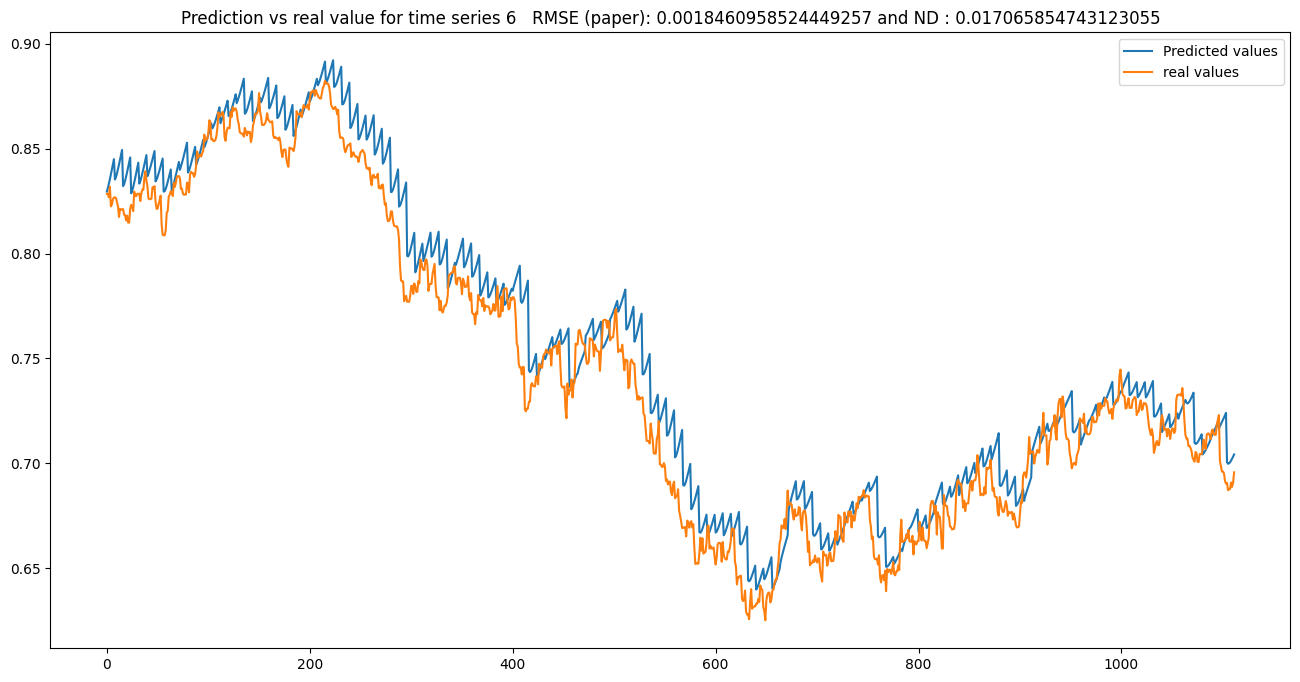

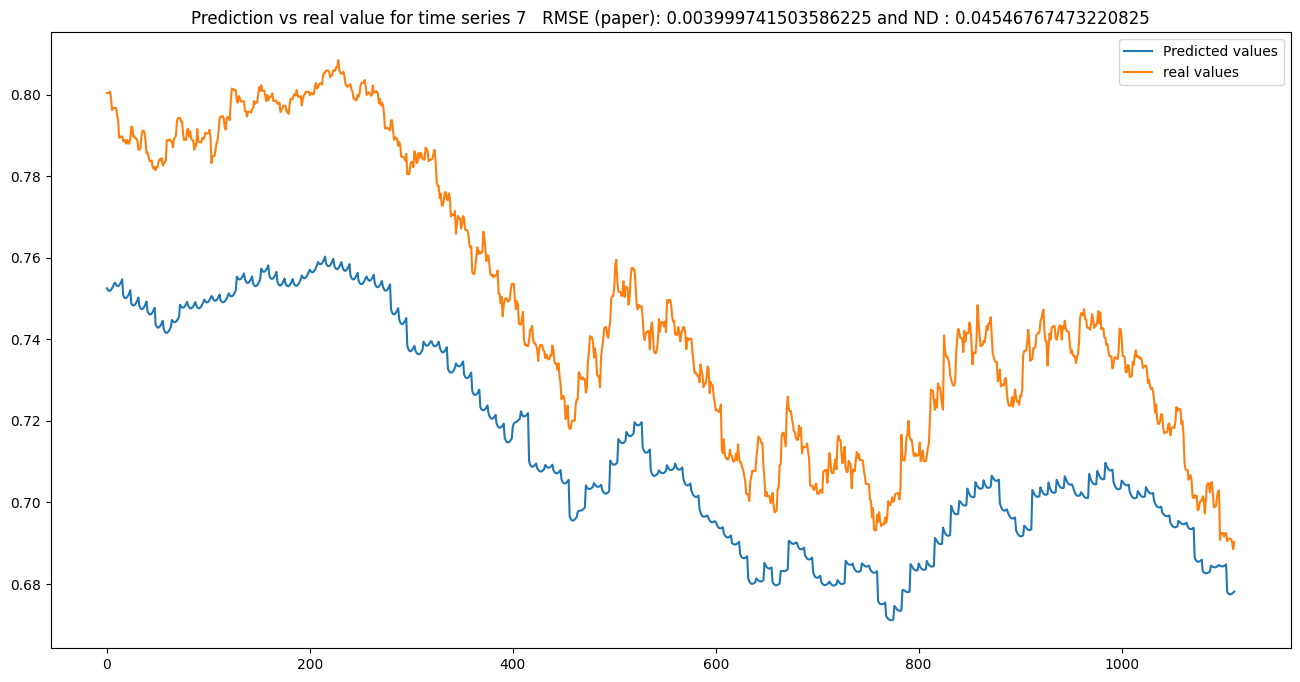

In [8]:
draw(res, horizon=test_horizon, n_nodes=n_nodes)